## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning
## Name: Shanshan Qu   
## username: shanshaq

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html (This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others.)
### Delivering

**Deadline**: Wednesday, March 25, 2020, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution. (If you have problems making a pdf at your own machine, you can make it at the IFI linux cluster.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the exercise
This exercise has three parts. The goal of the first part is to get some more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Beware
This is a new assignment. There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your
own and explain them!

### Intialization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the and of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [1]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [11]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [32]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [15]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

In [31]:
def show(X, y, marker='.'):
    labels = set(y)
    cl = {lab : [] for lab in labels}
    # cl[lab] shall contain the datapoints labeled cl
    for (a, b) in zip(X, y):
        cl[b].append(a)
    for lab in labels:
        plt.plot([a[0] for a in cl[lab]], [a[1] for a in cl[lab]], 
                 marker, label="class {}".format(lab))
    plt.legend()

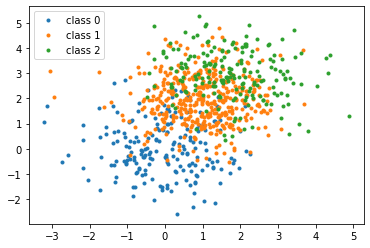

In [297]:
# Dataset(X,t)
show(X_train,t_train)

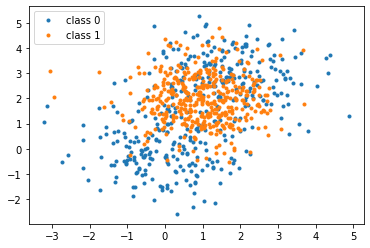

In [34]:
# Dataset(X,t2)
show(X_train,t2_train)

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

In [104]:
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1) 
    
def mse(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += (y[i] - y_pred[i])**2
    mean_squared_error = sum_errors/len(y)
    return mean_squared_error

In [49]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)

In [658]:
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.1, epochs= 10, diff= 0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        error=0

        for e in range(epochs):
            theta -= gamma / k *  X_train.T @ (X_train @ theta - t_train)
            new_error = mse(t_train, X_train @ theta)
            
            if abs(new_error - error) < diff:
                print(f"Fit method stop after {e} epochs")
                break
            error = new_error
            
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.theta
        return score>threshold

In [659]:
# Here I choose diff=10e-9 as optimal after testing, there's no need to make it smaller because the result remain same
for e in [1, 2, 5, 10, 50, 100, 1000, 5000, 10000]:
    lin_cl = NumpyLinRegClass()
    lin_cl.fit(X_train, t2_train, gamma=0.1, epochs= e, diff=10e-9)
    print(lin_cl.accuracy(X_val, t2_val))

0.445
0.47
0.4925
0.495
0.56
0.5925
Fit method stop after 179 epochs
0.6075
Fit method stop after 179 epochs
0.6075
Fit method stop after 179 epochs
0.6075


### Logistic regression
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [660]:
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, gamma = 0.1, epochs=10, diff= 0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        error = 0
        
        for e in range(epochs):
            theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train)  
            new_error = mse(t_train, X_train @ theta)
            
            if abs(new_error - error) < diff:
                print(f"Fit method stop after {e} epochs")
                break  
            error = new_error
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        # score = z @ self.theta
        return (score>threshold).astype('int')

In [661]:
# Here I choose diff=10e-6 as optimal
for e in [1, 2, 5, 10, 50, 100, 1000, 5000, 10000]:
    lr_cl = NumpyLogReg()
    lr_cl.fit(X_train, t2_train, gamma=0.1, epochs= e, diff=10e-6)
    print(lr_cl.accuracy(X_val, t2_val))

0.5875
0.5875
0.595
0.595
0.64
0.6375
Fit method stop after 621 epochs
0.605
Fit method stop after 621 epochs
0.605
Fit method stop after 621 epochs
0.605


### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You therefore have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X2_val, x2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

In [35]:
class PyClassifier():
    """Common methods to all python classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)

In [36]:
from collections import Counter

def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: self.k]]
        return majority(predictors)

In [416]:
x = range(1, 20, 1)
for k in x:
    cls = PykNNClassifier(k=k)
    cls.fit(X_train, t2_train)
    test= cls.accuracy(X_val, t2_val)
    print("k={:2}, accuracy: {:6.4f}".format(
    k, test))
    # when k = 14 accuracy 0.7675 is optimal

k= 1, accuracy: 0.6700
k= 2, accuracy: 0.6700
k= 3, accuracy: 0.6800
k= 4, accuracy: 0.6875
k= 5, accuracy: 0.7125
k= 6, accuracy: 0.7200
k= 7, accuracy: 0.7350
k= 8, accuracy: 0.7375
k= 9, accuracy: 0.7325
k=10, accuracy: 0.7400
k=11, accuracy: 0.7375
k=12, accuracy: 0.7525
k=13, accuracy: 0.7475
k=14, accuracy: 0.7675
k=15, accuracy: 0.7525
k=16, accuracy: 0.7550
k=17, accuracy: 0.7500
k=18, accuracy: 0.7575
k=19, accuracy: 0.7525


### Simple perceptron
Finally, run the simple perceptron (week05) on the same set, and report and store accuracy.

In [78]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data eith learning
        rate eta, running epochs many epochs"""
        X_train = [[1]+list(x) for x in X_train] # Put bias in position 0      
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0. There are better ways!

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] += eta * (t - y) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

In [408]:
for i in range(1,20):
    cl = PyPerClassifier()
    cl.fit(X_train, t2_train, eta= 0.1, epochs = i)
    test = cl.accuracy(X_val, t2_val)
    print("Accuracy after {:2} epochs, test: {:6.4f}".format(
    i, test))
# Accuracy after 17 epochs 0.6625 which is optimal

Accuracy after  1 epochs, test: 0.6475
Accuracy after  2 epochs, test: 0.6500
Accuracy after  3 epochs, test: 0.5925
Accuracy after  4 epochs, test: 0.5875
Accuracy after  5 epochs, test: 0.6475
Accuracy after  6 epochs, test: 0.6250
Accuracy after  7 epochs, test: 0.5825
Accuracy after  8 epochs, test: 0.6500
Accuracy after  9 epochs, test: 0.6500
Accuracy after 10 epochs, test: 0.5950
Accuracy after 11 epochs, test: 0.5825
Accuracy after 12 epochs, test: 0.5650
Accuracy after 13 epochs, test: 0.6125
Accuracy after 14 epochs, test: 0.6475
Accuracy after 15 epochs, test: 0.5925
Accuracy after 16 epochs, test: 0.5825
Accuracy after 17 epochs, test: 0.6625
Accuracy after 18 epochs, test: 0.5975
Accuracy after 19 epochs, test: 0.5950


### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

<table style="width=80%">
<tr>
<th>Classifiers</th>
<th>Accuracy</th>
</tr>

<tr>
<td>Linear regression</td>
<td>0.6075</td>

</tr>
<tr>
<td>Logistic regression</td>
<td>0.64</td>

</tr>
<tr>
<td>kNN</td>
<td>0.7675</td>

</tr>
<tr>
<td>Simple perceptron</td>
<td>0.6625</td>

</tr>
</table>
From the scatter plot, we can see linear regression is not very suitable for this case. Logistic regression is just like a classification model and is often used for binary classification, which means it gives a relative better result. kNN is also a good model for this because there are not much overlap between different categories. The result is similar as what I have expected. Among these classifiers, kNN perform well and get the best accuracy result, and linear regression is the worst.

## Multi-class classifiers
We now turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

0.77


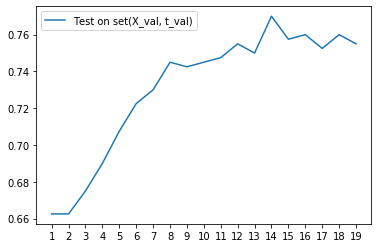

In [425]:
x = range(1, 20, 1)
accuracies = []
for k in x:
    cls = PykNNClassifier(k=k)
    cls.fit(X_train, t_train)
    accuracies.append(cls.accuracy(X_val, t_val))
plt.plot(x, accuracies, label="Test on set(X_val, t_val)")
plt.xticks(x)
plt.legend()
print(accuracies[13]) # when k = 14, optimal accuracy:0.77

### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

In [690]:
class NumpyLogRegOvR(NumpyClassifier):
    def fit(self, X_train, t_train, gamma = 0.1, epochs=10, diff= 0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        error = 0
        self.thetas = thetas =[]
        self.classes = classes = t_train.shape[1] # number of classes
        
        for i in range(classes):
            for e in range(epochs):
                theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train[:,i])  
                new_error = mse(t_train[:,i], X_train @ theta)
            
                if abs(new_error - error) < diff:
                    break
                error = new_error
            thetas.append(list(theta))
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = []
        # score = self.forward(z)
        for i in range(self.classes):
            score.append(z @ self.thetas[i])
        # score = z @ self.thetas
        return np.argmax(score, axis=0)

In [795]:
# Method to change representation of classes, i.e. 0 to [1, 0, 0]   
def modify_t(t):
    classes = np.unique(t).tolist()
    t_train_m = np.zeros((len(t), len(classes)))
    for i,n in enumerate(t):
        t_train_m[i][classes.index(n)] = 1
    return t_train_m     

for e in [1, 2, 5, 10, 50, 100, 1000, 5000, 10000]:
    lr_cl_ovr = NumpyLogRegOvR()
    lr_cl_ovr.fit(X_train, modify_t(t_train), gamma=0.1, epochs= e, diff=10e-6)
    print(lr_cl_ovr.accuracy(X_val, t_val))

0.58
0.575
0.57
0.57
0.59
0.63
0.7625
0.74
0.74


*  We're actually doing is going from a binary classifier to three binary classifiers, and we are not changing too much. We only change the data representation, and the way we make prediction.
*  The results on the three-class classification task is better than the results on the binary task. 
*  I think the reason may be more features, and the accuracy has been improved because of that.

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g. on the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

In [663]:
# Add 3 features to X_train and X_val: X_train_5f and X_val_5f
X_train_5f = X_train.copy()
c1=np.asarray([np.square(i[0]) for i in X_train_5features]).reshape(800,1)
c2=np.asarray([np.square(i[1]) for i in X_train_5features]).reshape(800,1)
c3=np.asarray([(i[0]*i[1]) for i in X_train_5features]).reshape(800,1)
X_train_5f = np.column_stack((X_train_5f,c1,c2,c3))

X_val_5f = X_val.copy()
c1=X_val_5f[:,0] * X_val_5f[:,0]
c2=X_val_5f[:,1] * X_val_5f[:,1]
c3=X_val_5f[:,0] * X_val_5f[:,1]
X_val_5f = np.column_stack((X_val_5f,c1,c2,c3))

# Linear regression
for e in [1, 2, 5, 10, 50, 100, 1000, 5000, 10000]:
    lin_cl = NumpyLinRegClass()
    lin_cl.fit(X_train_5f, t2_train, gamma=0.01, epochs= e, diff=10e-9)
    print(lin_cl.accuracy(X_val_5f, t2_val))
print("-------------------------------")
# Logistic regression
for e in [1, 2, 5, 10, 50, 100, 1000, 10000]:
    lr_cl = NumpyLogReg()
    lr_cl.fit(X_train_5f, t2_train, gamma=0.1, epochs= e, diff=10e-8)
    print(lr_cl.accuracy(X_val_5f, t2_val))
print("-------------------------------")
# kNN : optimal accuracy 0.7625 when k=13
x = range(1, 20, 1)
for k in x:
    cls = PykNNClassifier(k=k)
    cls.fit(X_train_5f, t2_train)
    test= cls.accuracy(X_val_5f, t2_val)
    print("k={:2}, accuracy: {:6.4f}".format(
    k, test))
print("-------------------------------")
# Simple perceptron: optimal accuracy 0.6475 after 13 epochs
for i in range(1,20):
    cl = PyPerClassifier()
    cl.fit(X_train_5f, t2_train, eta= 0.1, epochs = i)
    test = cl.accuracy(X_val_5f, t2_val)
    print("Accuracy after {:2} epochs, test: {:6.4f}".format(i, test)) 

0.465
0.45
0.445
0.445
0.4775
0.595
0.71
Fit method stop after 1644 epochs
0.7075
Fit method stop after 1644 epochs
0.7075
-------------------------------
0.63
0.615
0.6325
0.6725
0.695
0.695
0.7325
Fit method stop after 7845 epochs
0.7375
-------------------------------
k= 1, accuracy: 0.6950
k= 2, accuracy: 0.6950
k= 3, accuracy: 0.6925
k= 4, accuracy: 0.7075
k= 5, accuracy: 0.7075
k= 6, accuracy: 0.7150
k= 7, accuracy: 0.7225
k= 8, accuracy: 0.7325
k= 9, accuracy: 0.7275
k=10, accuracy: 0.7375
k=11, accuracy: 0.7525
k=12, accuracy: 0.7600
k=13, accuracy: 0.7625
k=14, accuracy: 0.7600
k=15, accuracy: 0.7525
k=16, accuracy: 0.7525
k=17, accuracy: 0.7500
k=18, accuracy: 0.7500
k=19, accuracy: 0.7450
-------------------------------
Accuracy after  1 epochs, test: 0.6100
Accuracy after  2 epochs, test: 0.6175
Accuracy after  3 epochs, test: 0.6150
Accuracy after  4 epochs, test: 0.6350
Accuracy after  5 epochs, test: 0.6200
Accuracy after  6 epochs, test: 0.6450
Accuracy after  7 epochs,

<table style="width=80%">
<tr>
<th>Classifiers</th>
<th>Accuracy (original features)</th>
<th>Accuracy (with three additional features)</th>
</tr>

<tr>
<td>Linear regression</td>
<td>0.6075</td>
<td>0.71</td>
</tr>
<tr>
<td>Logistic regression</td>
<td>0.64</td>
<td>0.7375</td>
</tr>
<tr>
<td>kNN</td>
<td>0.7675</td>
<td>0.7625</td>
</tr>
<tr>
<td>Simple perceptron</td>
<td>0.6625</td>
<td>0.6475</td>
</tr>
</table>

We use the extended array with 3 extra features instead of the original ones, and find out much better results in linear regression and logistic regression. That means more non-linear features can improve the accuracies of the linear classifiers, but do not work on non-linear classifiers like kNN.


# Part II
## Multi-layer neural networks
We will now implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do it in two steps. In the first step, we will work concretely with the dataset (X, t). We will initailize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

In [502]:
def scaler(X):
    (k, m) = X.shape
    mean = (1/k) * np.sum(X, axis=0)
    sd = np.std(X, axis=0)
    return (X - mean) / sd

X_scaled = scaler(X)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# print(X_scaled)

## Step1: One round of training

### Intializing
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [735]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *y_train*. Beware that *y_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [884]:
dim_in  = scaler(X_train).shape[1]
dim_out = np.unique(t_train).shape[0]  
print("dim_in =", dim_in)
print("dim_out =", dim_out)

dim_in = 2
dim_out = 3


We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [905]:
weights1 = np.random.random((dim_in+1, dim_hidden))
weights2 = np.random.random((dim_hidden+1, dim_out))

print(weights1)
print(weights2)

[[0.46914271 0.69795059 0.79562993 0.53616728 0.30766063 0.49263133]
 [0.50737942 0.66083847 0.43815843 0.06215142 0.05974326 0.22291276]
 [0.4181899  0.26792144 0.89198534 0.54312441 0.71366931 0.74978505]]
[[0.4908737  0.67819121 0.79116135]
 [0.08580698 0.49015303 0.40124406]
 [0.83398148 0.70810224 0.85743535]
 [0.76837459 0.3974894  0.91956995]
 [0.37209349 0.98929456 0.10565506]
 [0.83588533 0.68667415 0.19470485]
 [0.19600195 0.17491885 0.50809755]]


### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [906]:
def logistic_activation(X, W):
        return 1 / (1 + np.exp(-1 * (X @ W)))
    
hidden_activations = logistic_activation(add_bias(scaler(X_train)), weights1)
print(hidden_activations)

[[0.64544721 0.73355712 0.65218581 0.57282466 0.49338156 0.56267355]
 [0.77505997 0.83197447 0.83858854 0.69111077 0.65352571 0.73720715]
 [0.39964195 0.44599381 0.4025285  0.506674   0.41612463 0.4121569 ]
 ...
 [0.28003011 0.35004124 0.19303856 0.36155975 0.24653842 0.23139747]
 [0.73729283 0.80558571 0.7857802  0.65063001 0.59784401 0.68116125]
 [0.54082675 0.61738856 0.54727237 0.5452949  0.46093243 0.49838815]]


In [907]:
output_activations = logistic_activation(add_bias(hidden_activations), weights2)
print(output_activations)

[[0.91644473 0.94142774 0.93827362]
 [0.94498198 0.96238331 0.95935915]
 [0.86099217 0.90105238 0.88575037]
 ...
 [0.79267444 0.84651187 0.82990403]
 [0.93732626 0.95671463 0.95397949]
 [0.89646538 0.92697559 0.91992877]]


### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [908]:
delta_output = output_activations * (modify_t(t_train) - output_activations) *  (1 - output_activations)
print(delta_output)

[[-0.07017564  0.00322977 -0.05434128]
 [-0.04913059  0.00136179 -0.03740462]
 [ 0.0166371  -0.08033511 -0.08963497]
 ...
 [ 0.03407223 -0.10998688 -0.11715202]
 [-0.05506393  0.00179252 -0.0418822 ]
 [-0.08320562 -0.06274869  0.00589803]]


Calculate the error in the hidden layer.

In [909]:
delta_hidden = hidden_activations * (1- hidden_activations) * (delta_output @ weights2.T[:,1:])
print(delta_hidden)

[[-0.00600549 -0.02009869 -0.02327554 -0.00701255 -0.01675244 -0.01003981]
 [-0.0032352  -0.01007652 -0.00969237 -0.00445866 -0.01073624 -0.00550137]
 [-0.01773416 -0.02961705 -0.02442859 -0.02068504 -0.0142644  -0.01364893]
 ...
 [-0.01975675 -0.03410789 -0.01951356 -0.02504762 -0.01297602 -0.01282055]
 [-0.00399998 -0.01261777 -0.01348503 -0.00526012 -0.01273081 -0.00689751]
 [-0.00882316 -0.02569299 -0.02067635 -0.02291391 -0.02770231 -0.00607184]]


Update the weights.
Check that they have changed.

In [910]:
update_w1 = np.zeros((np.shape(weights1)))
update_w2 = np.zeros((np.shape(weights2)))

update_w1 = eta * (add_bias(scaler(X_train)).T) @ delta_hidden
update_w2 = eta * (add_bias(hidden_activations).T) @ delta_output

weights1 += update_w1
weights2 += update_w2

print(weights1)
print(weights2)

[[0.40475446 0.53716165 0.66137507 0.45132358 0.19811718 0.42754104]
 [0.53546035 0.715073   0.47920451 0.08816673 0.06995962 0.24566037]
 [0.45634197 0.32483777 0.94059731 0.58378944 0.72895377 0.77723925]]
[[ 0.17024187  0.45809667  0.39229681]
 [-0.13168174  0.38709812  0.20356162]
 [ 0.6037418   0.59223042  0.63815934]
 [ 0.52212876  0.29680074  0.71478988]
 [ 0.15304697  0.8763498  -0.11146866]
 [ 0.62921789  0.59147381  0.00737131]
 [-0.02690034  0.07661261  0.31306557]]


##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [1092]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

    def fit(self, X_train, t_train, epochs = 100, t= 0.0001):
        """Intialize the weights. Train *epochs* many epochs."""
        
        X_train = scaler(X_train) # Scale 
        
        dim_in  = X_train.shape[1]
        dim_out = t_train.shape[1]
        
        self.weights1 = weights1 = np.random.random((dim_in+1, dim_hidden))
        self.weights2 = weights2 = np.random.random((dim_hidden+1, dim_out))
        error = 0

        for e in range(epochs):
            # Run one epoch of forward-backward
            hidden_activations = self.forward(X_train)[0]
            output_activations = self.forward(X_train)[1]
            
            delta_output = output_activations * (t_train - output_activations) *  (1 - output_activations)
            delta_hidden = hidden_activations * (1- hidden_activations) * (delta_output @ weights2.T[:,1:])
            
            update_w1 = np.zeros((np.shape(weights1)))
            update_w2 = np.zeros((np.shape(weights2)))

            update_w1 = self.eta * (add_bias(X_train).T) @ delta_hidden
            update_w2 = self.eta * (add_bias(hidden_activations).T) @ delta_output
            
            weights1 += update_w1
            weights2 += update_w2
            
#             new_error = mse(self.forward(X_train)[1], modify_t(t_train))
            
#             if e>50 && abs(new_error - error) < t:
#                 # Training stopped after e epochs
#                 break
#             error = new_error
            
            self.weights1 = weights1
            self.weights2 = weights2

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.logistic_activation(add_bias(X), self.weights1)
        output_activations = self.logistic_activation(add_bias(hidden_activations), self.weights2)
        return hidden_activations, output_activations
    
    def predict(self, X):
        score = self.forward(X)[1]
        return np.argmax(score, axis=1)

    def accuracy(self, X_test, t_test):
        """Calculate the accuracy of the classifier on the pair (X_test, t_test)
        Return the accuracy"""
        hidden_activations, output_activations=self.forward(X_test)
        c = self.predict(X_test)
        return np.sum(c == t_test) / t_test.shape[0], self.mse(output_activations,modify_t(t_test))
    
    def logistic_activation(self, X, W):
        return 1 / (1 + np.exp(-1 * (X @ W)))
    
    def mse(self, A, B):
        return np.square(np.subtract(A,B)).mean()


Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [987]:
for e in [1, 2, 5, 10, 50, 100, 1000, 5000, 10000]:
    mlp = MNNClassifier()
    mlp.fit(X_train, modify_t(t_train), epochs= e)
    mse_t.append(mse(t_train, mlp.predict(X_train)))
    print(mlp.accuracy(scaler(X_val), t_val)[0])
#     print[mse_t]

0.285
0.185
0.4725
0.285
0.4725
0.5075
0.7625
0.755
0.75


The best accuracy is 0.7625

## For master's students: Early stopping
There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and plot them as in figure 4.11 in Marsland. 

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

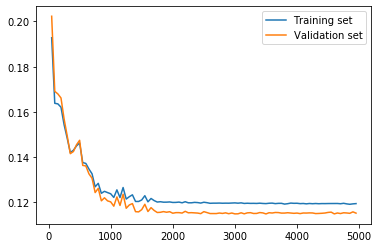

In [1091]:
mse_t=[]
mse_v=[]
e=50
for ep in np.arange(e, 5000, 50):
    mlp = MNNClassifier()
    mlp.fit(X_train, modify_t(t_train), epochs= ep)
    mse_t.append(mlp.accuracy(scaler(X_train), t_train)[1])
    mse_v.append(mlp.accuracy(scaler(X_val), t_val)[1])
    
    
plt.plot(np.arange(e, 5000, 50), mse_t, label="Training set" )
plt.plot(np.arange(e, 5000, 50), mse_v, label="Validation set")
plt.legend()
plt.show()    

The curve is not so smooth as I expected, but it seems ok. 
I just modified the code in the class above without any other changes on other problems, and then comment it out.

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

In [1058]:
# For (X, t2)
x = range(1, 20, 1)
for k in x:
    cls = PykNNClassifier(k=k)
    cls.fit(X_train, t2_train)
    test= cls.accuracy(X_test, t2_test)
#     print("k={:2}, accuracy: {:6.4f}".format(
#     k, test))
    
# for (X, t): Multiclass kNN and Logistic regression OvR have similar accuracies, I have tested both， and only keep Logistic regression OvR with good results。
    
for e in [1, 2, 5, 10, 50, 100, 1000, 5000, 10000]:
    lr_cl_ovr = NumpyLogRegOvR()
    lr_cl_ovr.fit(X_train, modify_t(t_train), gamma=0.1, epochs= e, diff=10e-6)
    print(lr_cl_ovr.accuracy(X_test, t_test))

0.5875
0.585
0.5825
0.5825
0.5875
0.6025
0.755
0.745
0.745


By using same method as above, I only change the validation sets to test sets.
For (X, t2), best k is 9, best accuracy is 0.7625
For (X, t), best accuracy is 0.755
The accuracies are still good compared to the results on the validation sets(0.7675, 0.7625). The difference between them are really small, and can be ignored. 

In [1101]:
def perf_measure(y_true, y_pred):
    TP, FP, TN, FN = 0, 0, 0, 0

    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
           TP += 1
        if y_true[i] == 0 and y_pred[i] == 1:
           FP += 1
        if y_true[i] == 0 and y_pred[i] == 0:
           TN += 1
        if y_true[i] == 1 and y_pred[i] == 0:
           FN += 1

    return TP, FP, TN, FN

# Confusion matrix for KNN(4 params in the matrix)
cls = PykNNClassifier(k=9)
cls.fit(X_train, t2_train)
matrix = perf_measure(list(t2_test),[cls.predict(a) for a in X_test])
print("-----------------------binary--------------------------")
print("TP, FP, TN, FN = ",matrix)
precision=matrix[0]/(matrix[0]+matrix[1])
print("Precision: ", precision)
recall=matrix[0]/(matrix[0]+matrix[3])
print("Recall: ", recall)
accuracy = (matrix[0]+matrix[1])/(matrix[0]+matrix[1]+matrix[2]+matrix[3])
print("Accuracy: ", accuracy)   

# Confusion matrix for Logistic regression OvR(4 params in the matrix)
lr_cl_ovr = NumpyLogRegOvR()
lr_cl_ovr.fit(X_train, modify_t(t_train), gamma=0.1, epochs= 2000, diff=10e-6)

matrix=[]
precision=[]
recall=[]
accuracies=[]

for i in range(0,3):
    print("-------------multiclasses class{:2}--------------".format(i))
    matrix.append(perf_measure(modify_t(list(t_test))[:,i], modify_t(lr_cl_ovr.predict(X_test))[:,i])) 
    print("TP, FP, TN, FN = ",matrix[i])
    precision.append(matrix[i][0]/(matrix[i][0]+matrix[i][1]))
    print("Precision: ", precision[i])
    recall.append(matrix[i][0]/(matrix[i][0]+matrix[i][3]))
    print("Recall: ", recall[i])
    accuracies.append((matrix[i][0]+matrix[i][1])/(matrix[i][0]+matrix[i][1]+matrix[i][2]+matrix[i][3]))
    print("Accuracy: ", accuracies[i])   

# from sklearn.metrics import confusion_matrix

# print(confusion_matrix(list(t2_test),[cls.predict(a) for a in X_test]).ravel())


-----------------------binary--------------------------
TP, FP, TN, FN =  (160, 60, 145, 35)
Precision:  0.7272727272727273
Recall:  0.8205128205128205
Accuracy:  0.55
-------------multiclasses class 0--------------
TP, FP, TN, FN =  (67, 7, 301, 25)
Precision:  0.9054054054054054
Recall:  0.7282608695652174
Accuracy:  0.185
-------------multiclasses class 1--------------
TP, FP, TN, FN =  (171, 75, 130, 24)
Precision:  0.6951219512195121
Recall:  0.8769230769230769
Accuracy:  0.615
-------------multiclasses class 2--------------
TP, FP, TN, FN =  (63, 17, 270, 50)
Precision:  0.7875
Recall:  0.5575221238938053
Accuracy:  0.2


As what I have understood, I just calculate the precision and recall for each classes in multiclass case. I didn't represent the confusion matrix in matrix form because I saw different ways of representing them, but I list all tp, fp, tn and fn, which formed the confusion matrix.